# 基于决策树算法实现电信用户流失预测任务

任务描述：随着电信行业的不断发展，运营商们越来越重视如何扩大其客户群体。据研究，获取新客户所需的成本远高于保留现有客户的成本，因此为了满足在激烈竞争中的优势，保留现有客户成为一大挑战。对电信行业而言，可以通过数据挖掘等方式来分析可能影响客户决策的各种因素，以预测他们是否会产生流失（停用服务、转投其他运营商等）。

数据集：本案例所使用数据集来自Kaggle平台，可以从这里下载。数据集一共提供了7043条用户样本，每条样本包含21列属性，由多个维度的客户信息以及用户是否最终流失的标签组成，客户信息具体如下： 基本信息：包括性别、年龄、经济情况、入网时间等； 开通业务信息：包括是否开通电话业务、互联网业务、网络电视业务、技术支持业务等； 签署的合约信息：包括合同年限、付款方式、每月费用、总费用等。

## 一、引入工具包

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE

import graphviz
from sklearn import tree

D:\Anaconda3\envs\Python3.6\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## 二、加载数据

In [2]:
data = pd.read_csv('../data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
pd.set_option('display.max_columns', None)
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 三、数据预处理

### 3.1 重复值处理

In [3]:
print("原数据集样本数量：{}".format(data.shape[0]))
print("数据集去重后样本数量：{}".format(data.drop_duplicates().shape[0]))

原数据集样本数量：7043
数据集去重后样本数量：7043


In [4]:
data.drop_duplicates().shape

(7043, 21)

可以得出该数据无重复值

### 3.2 缺失值处理

In [5]:
missingDf = data.isnull().sum().sort_values(ascending=False).reset_index()
missingDf.columns = ['feature', 'missing_num']
missingDf['missing_percentage'] = missingDf['missing_num'] / data.shape[0]
missingDf.head()

,feature,missing_num,missing_percentage
0,Churn,0,0.0
1,OnlineSecurity,0,0.0
2,gender,0,0.0
3,SeniorCitizen,0,0.0
4,Partner,0,0.0


统计结果告诉我们数据集中应该没有缺失值，但是可能存在这样的情况：采用 'Null'、'NaN'、' ' 等字符（串）表示缺失。数据集中就有这样一列TotalCharges特征，存在如下所示的11条样本，其特征值为空格字符（' '）：

In [6]:
data[data['TotalCharges'] == ' ']

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


In [7]:
# 将特征TotalCharges转为数值型
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'],errors='coerce')

In [8]:
# 使用MonthlyCharges填充TotalCharges
data['TotalCharges'] = data['TotalCharges'].fillna(data['MonthlyCharges']) 

### 3.3 异常值处理

[Text(0.5, 0, 'TotalCharges')]

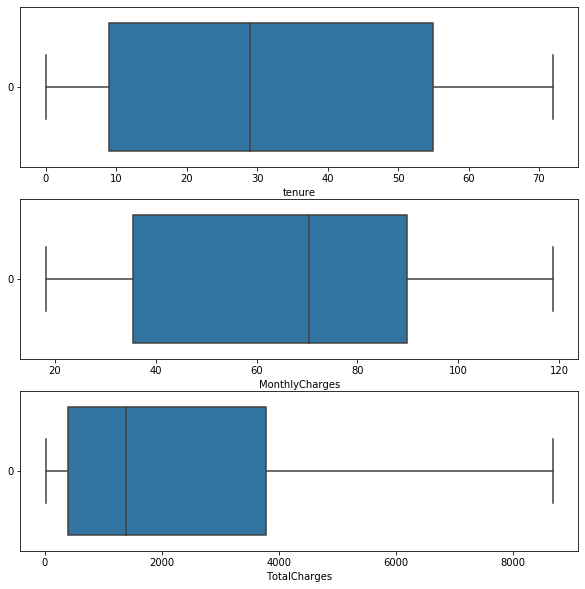

In [9]:
fig = plt.figure(figsize=(10,10))

# tenure
ax1 = fig.add_subplot(3,1,1)
sns.boxplot(data = data['tenure'],orient='h',ax=ax1).set(xlabel='tenure')

# MonthlyCharges
ax2 = fig.add_subplot(3,1,2)
sns.boxplot(data = data['MonthlyCharges'],orient='h',ax=ax2).set(xlabel='MonthlyCharges')

# TotalCharges
ax3 = fig.add_subplot(3,1,3)
sns.boxplot(data = data['TotalCharges'],orient='h',ax=ax3).set(xlabel='TotalCharges')

## 四、特征选择

### 4.1 基本特征对客户流失影响

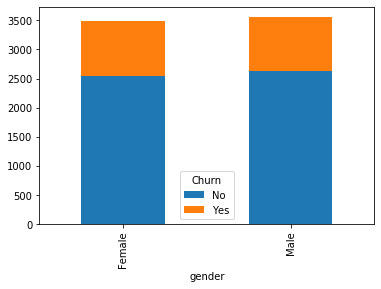

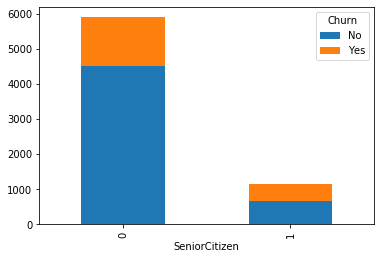

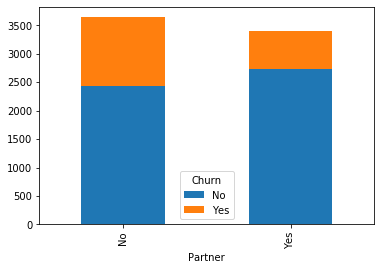

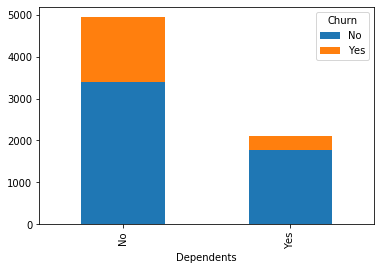

In [10]:
### 性别、是否老年人、是否有配偶、是否有家属等特征对客户流失的影响
baseCols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']

for i in baseCols:
    cnt = pd.crosstab(data[i], data['Churn'])    # 构建特征与目标变量的列联表
    cnt.plot.bar(stacked=True)    # 绘制堆叠条形图，便于观察不同特征值流失的占比情况
    plt.show()    # 展示图像

由图可知：

- 性别对客户流失基本没有影响
- 年龄对客户流失有影响，老年人流失占比高于年轻人
- 是否有配偶对客户流失有影响，无配偶客户流失占比高于有配偶客户
- 是否有家属对客户流失有影响，无家属客户流失占比高于有家属客户

### 4.2 业务特征对客户流失影响

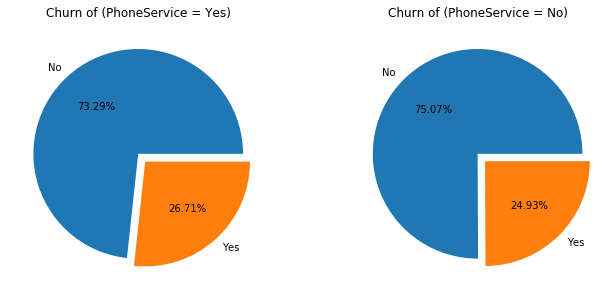

In [11]:
# 电话业务
posDf = data[data['PhoneService'] == 'Yes']
negDf = data[data['PhoneService'] == 'No']

fig = plt.figure(figsize=(10,4)) # 建立图像

ax1 = fig.add_subplot(121)
p1 = posDf['Churn'].value_counts()
ax1.pie(p1,labels=['No','Yes'],autopct='%1.2f%%',explode=(0,0.1))
ax1.set_title('Churn of (PhoneService = Yes)')

ax2 = fig.add_subplot(122)
p2 = negDf['Churn'].value_counts()
ax2.pie(p2,labels=['No','Yes'],autopct='%1.2f%%',explode=(0,0.1))
ax2.set_title('Churn of (PhoneService = No)')

plt.tight_layout(pad=0.5)    # 设置子图之间的间距
plt.show() # 展示饼状图

##### 由图可知，是否开通电话业务对客户流失影响较小。

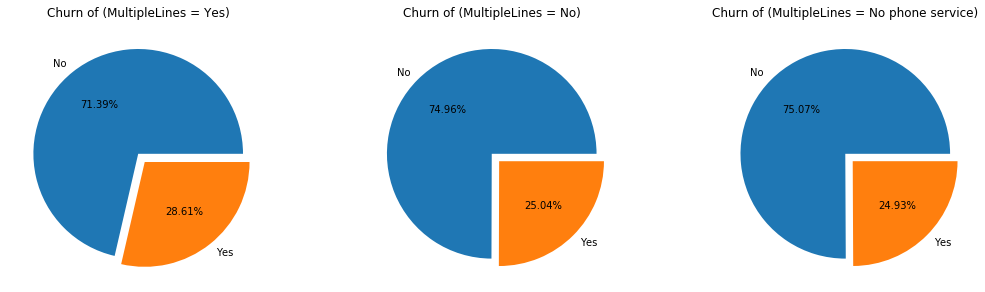

In [12]:
# 多线业务
df1 = data[data['MultipleLines'] == 'Yes']
df2 = data[data['MultipleLines'] == 'No']
df3 = data[data['MultipleLines'] == 'No phone service']

fig = plt.figure(figsize=(15,4)) # 建立图像

ax1 = fig.add_subplot(131)
p1 = df1['Churn'].value_counts()
ax1.pie(p1,labels=['No','Yes'],autopct='%1.2f%%',explode=(0,0.1))
ax1.set_title('Churn of (MultipleLines = Yes)')

ax2 = fig.add_subplot(132)
p2 = df2['Churn'].value_counts()
ax2.pie(p2,labels=['No','Yes'],autopct='%1.2f%%',explode=(0,0.1))
ax2.set_title('Churn of (MultipleLines = No)')

ax3 = fig.add_subplot(133)
p3 = df3['Churn'].value_counts()
ax3.pie(p3,labels=['No','Yes'],autopct='%1.2f%%',explode=(0,0.1))
ax3.set_title('Churn of (MultipleLines = No phone service)')

plt.tight_layout(pad=0.5)    # 设置子图之间的间距
plt.show() # 展示饼状图

由图可知，是否开通多线业务对客户流失影响很小。此外MultipleLines 取值为No和No phone service的两种情况基本一致，后续可以合并在一起。

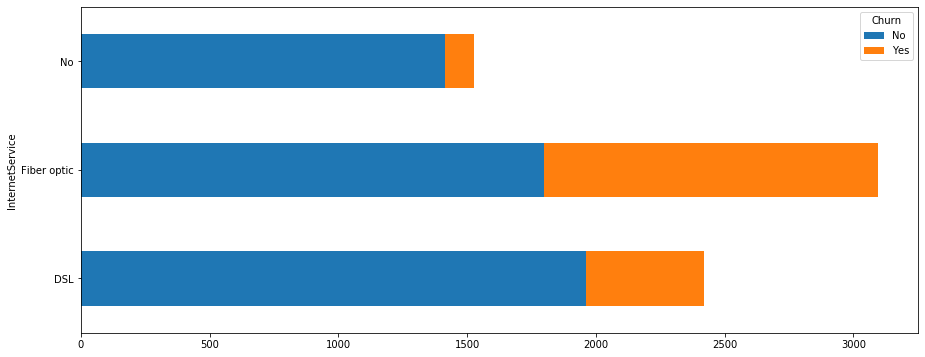

In [13]:
# 互联网业务
cnt = pd.crosstab(data['InternetService'], data['Churn'])    # 构建特征与目标变量的列联表
cnt.plot.barh(stacked=True, figsize=(15,6))    # 绘制堆叠条形图，便于观察不同特征值流失的占比情况
plt.show()    # 展示图像

由图可知，未开通互联网的客户总数最少，而流失比例最低（7.40%）；开通光纤网络的客户总数最多，流失比例也最高（41.89%）；开通数字网络的客户则均居中（18.96%）。可以推测应该有更深层次的因素导致光纤用户流失更多客户，下一步观察与互联网相关的各项业务

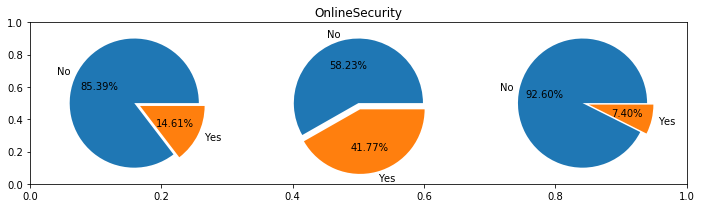

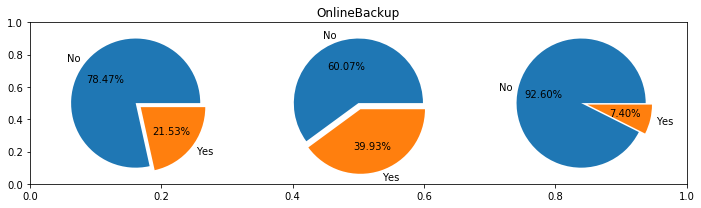

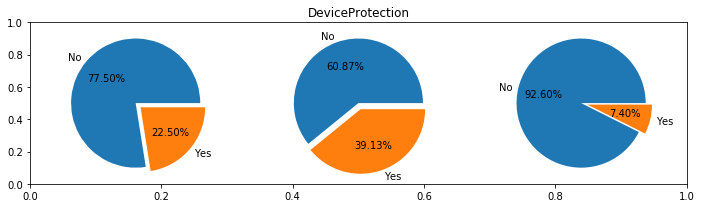

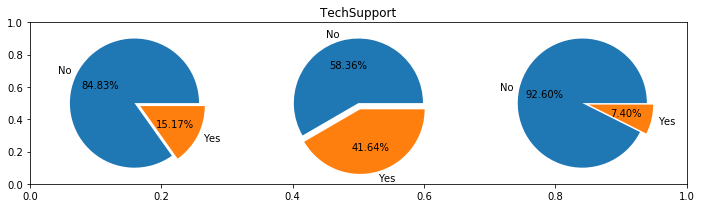

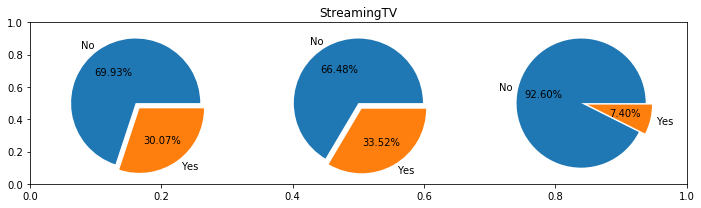

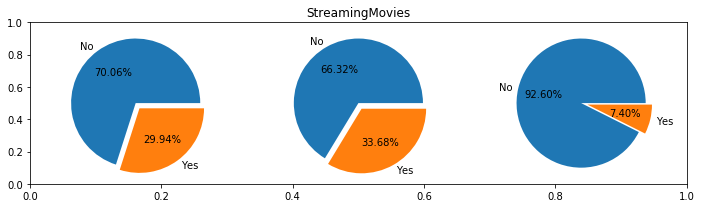

In [14]:
# 与互联网相关的业务
internetCols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

for i in internetCols:
    df1 = data[data[i] == 'Yes']
    df2 = data[data[i] == 'No']
    df3 = data[data[i] == 'No internet service']

    fig = plt.figure(figsize=(10,3)) # 建立图像
    plt.title(i)
    
    ax1 = fig.add_subplot(131)
    p1 = df1['Churn'].value_counts()
    ax1.pie(p1,labels=['No','Yes'],autopct='%1.2f%%',explode=(0,0.1))    # 开通业务

    ax2 = fig.add_subplot(132)
    p2 = df2['Churn'].value_counts()
    ax2.pie(p2,labels=['No','Yes'],autopct='%1.2f%%',explode=(0,0.1))    # 未开通业务

    ax3 = fig.add_subplot(133)
    p3 = df3['Churn'].value_counts()
    ax3.pie(p3,labels=['No','Yes'],autopct='%1.2f%%',explode=(0,0.1))    # 未开通互联网业务
  
    plt.tight_layout()    # 设置子图之间的间距
    plt.show() # 展示饼状图

由图可知：所有互联网相关业务中未开通互联网的客户流失率均为7.40%，可以判断原因是上述六列特征均只在客户开通互联网业务之后才有实际意义，因而不会影响未开通互联网的客户；开通了这些新业务之后，用户的流失率会有不同程度的降低，可以认为多绑定业务有助于用户的留存；'StreamingTV’和 'StreamingMovies’两列特征对客户流失基本没有影响。此外，由于 ‘No internet service’ 也算是 ‘No’ 的一种情况，因此后续步骤中可以考虑将两种特征值进行合并。

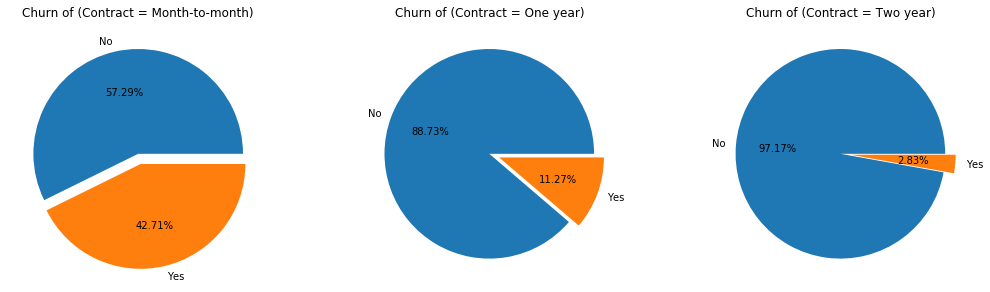

In [15]:
# 合约期限
df1 = data[data['Contract'] == 'Month-to-month']
df2 = data[data['Contract'] == 'One year']
df3 = data[data['Contract'] == 'Two year']

fig = plt.figure(figsize=(15,4)) # 建立图像

ax1 = fig.add_subplot(131)
p1 = df1['Churn'].value_counts()
ax1.pie(p1,labels=['No','Yes'],autopct='%1.2f%%',explode=(0,0.1))
ax1.set_title('Churn of (Contract = Month-to-month)')

ax2 = fig.add_subplot(132)
p2 = df2['Churn'].value_counts()
ax2.pie(p2,labels=['No','Yes'],autopct='%1.2f%%',explode=(0,0.1))
ax2.set_title('Churn of (Contract = One year)')

ax3 = fig.add_subplot(133)
p3 = df3['Churn'].value_counts()
ax3.pie(p3,labels=['No','Yes'],autopct='%1.2f%%',explode=(0,0.1))
ax3.set_title('Churn of (Contract = Two year)')

plt.tight_layout(pad=0.5)    # 设置子图之间的间距
plt.show() # 展示饼状图

由图可知：合约期限越长，用户的流失率越低。

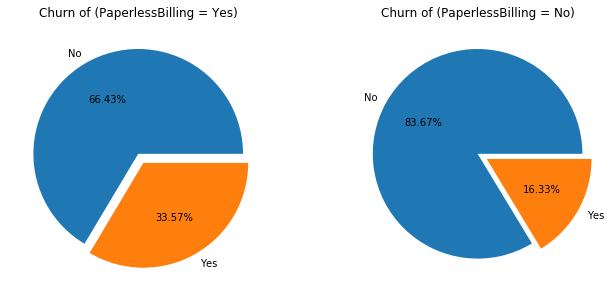

In [16]:
# 是否采用电子结算
df1 = data[data['PaperlessBilling'] == 'Yes']
df2 = data[data['PaperlessBilling'] == 'No']

fig = plt.figure(figsize=(10,4)) # 建立图像

ax1 = fig.add_subplot(121)
p1 = df1['Churn'].value_counts()
ax1.pie(p1,labels=['No','Yes'],autopct='%1.2f%%',explode=(0,0.1))
ax1.set_title('Churn of (PaperlessBilling = Yes)')

ax2 = fig.add_subplot(122)
p2 = df2['Churn'].value_counts()
ax2.pie(p2,labels=['No','Yes'],autopct='%1.2f%%',explode=(0,0.1))
ax2.set_title('Churn of (PaperlessBilling = No)')

plt.tight_layout(pad=0.5)    # 设置子图之间的间距
plt.show() # 展示饼状图

由图可知：采用电子结算的客户流失率较高，原因可能是电子结算多维按月支付的形式

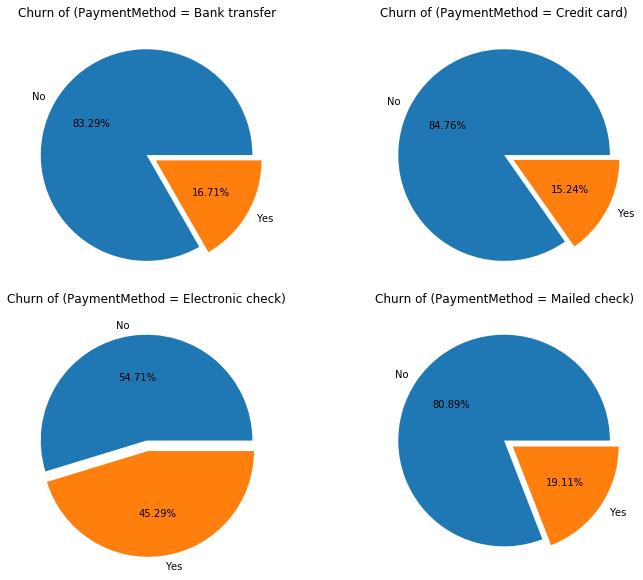

In [17]:
# 付款方式
df1 = data[data['PaymentMethod'] == 'Bank transfer (automatic)']    # 银行转账（自动）
df2 = data[data['PaymentMethod'] == 'Credit card (automatic)']    # 信用卡（自动）
df3 = data[data['PaymentMethod'] == 'Electronic check']    # 电子支票
df4 = data[data['PaymentMethod'] == 'Mailed check']    # 邮寄支票

fig = plt.figure(figsize=(10,8)) # 建立图像

ax1 = fig.add_subplot(221)
p1 = df1['Churn'].value_counts()
ax1.pie(p1,labels=['No','Yes'],autopct='%1.2f%%',explode=(0,0.1))
ax1.set_title('Churn of (PaymentMethod = Bank transfer')

ax2 = fig.add_subplot(222)
p2 = df2['Churn'].value_counts()
ax2.pie(p2,labels=['No','Yes'],autopct='%1.2f%%',explode=(0,0.1))
ax2.set_title('Churn of (PaymentMethod = Credit card)')

ax3 = fig.add_subplot(223)
p3 = df3['Churn'].value_counts()
ax3.pie(p3,labels=['No','Yes'],autopct='%1.2f%%',explode=(0,0.1))
ax3.set_title('Churn of (PaymentMethod = Electronic check)')

ax4 = fig.add_subplot(224)
p4 = df4['Churn'].value_counts()
ax4.pie(p4,labels=['No','Yes'],autopct='%1.2f%%',explode=(0,0.1))
ax4.set_title('Churn of (PaymentMethod = Mailed check)')

plt.tight_layout(pad=0.5)    # 设置子图之间的间距
plt.show() # 展示饼状图

由图可知，四种付款方式中采用电子支票的客户流失率远高于其他三种。

## 五、特征工程

### 5.1 删除明显和预测值无关的特征

In [18]:
data.drop(['customerID', 'gender', 'PhoneService', 'StreamingTV', 'StreamingMovies'],inplace=True,axis=1)
data.shape

(7043, 16)

### 5.2 相关系数矩阵衡量连续型特征相关性

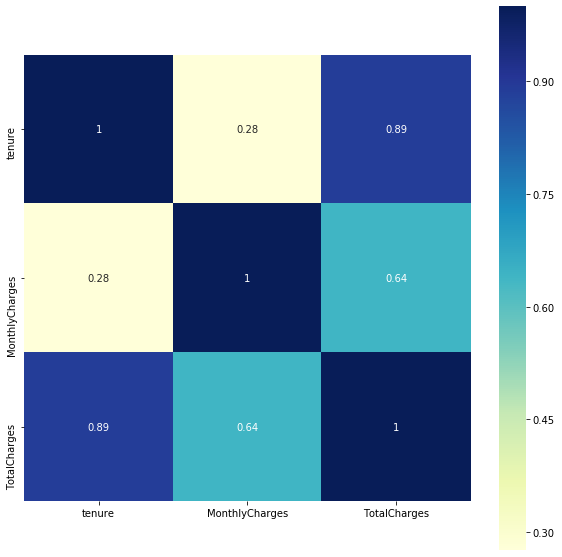

In [19]:
pearson_mat = data[['tenure', 'MonthlyCharges', 'TotalCharges']].corr(method='spearman')

plt.figure(figsize=(10,10))
ax = sns.heatmap(pearson_mat,square=True,annot=True,cmap='YlGnBu')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

由图可知，TotalCharges和tenure相关系数达到0.89，可以视作高度相关，因此可以删除该列，避免特征冗余

In [20]:
data = data.drop(['TotalCharges'], axis=1)

In [21]:
data.shape

(7043, 15)

### 5.3 卡方检验衡量离散型特征相关性

### 5.4 特征标准化

NO 和 No internet service意义相同，将其合并

In [22]:
for fea in ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport']:
    data.loc[data[fea] == 'No internet service',fea] = 'No'

NO 和 No phone service意义相同，将其合并

In [23]:
data.loc[data['MultipleLines'] == 'No phone service','MultipleLines'] = 'No'

##### 将二分类变量转为数值型变量

In [24]:
for fea in ['Partner','Dependents','MultipleLines','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport',"PaperlessBilling",'Churn']:
    data[fea] = data[fea].apply(lambda x :1 if x == 'Yes' else 0)

##### 将三分类变量转为数值型变量

In [25]:
for fea in  ['InternetService', 'Contract', 'PaymentMethod']:
    labels = data[fea].unique().tolist()
    data[fea] = data[fea].apply(lambda x:labels.index(x))

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 15 columns):
SeniorCitizen       7043 non-null int64
Partner             7043 non-null int64
Dependents          7043 non-null int64
tenure              7043 non-null int64
MultipleLines       7043 non-null int64
InternetService     7043 non-null int64
OnlineSecurity      7043 non-null int64
OnlineBackup        7043 non-null int64
DeviceProtection    7043 non-null int64
TechSupport         7043 non-null int64
Contract            7043 non-null int64
PaperlessBilling    7043 non-null int64
PaymentMethod       7043 non-null int64
MonthlyCharges      7043 non-null float64
Churn               7043 non-null int64
dtypes: float64(1), int64(14)
memory usage: 825.5 KB


## 六、模型训练

### 6.1 切分特征和标签

In [27]:
X = data.iloc[:,0:-1]
y = data['Churn']

In [28]:
X.head()

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges
0,0,1,0,1,0,0,0,1,0,0,0,1,0,29.85
1,0,0,0,34,0,0,1,0,1,0,1,0,1,56.95
2,0,0,0,2,0,0,1,1,0,0,0,1,1,53.85
3,0,0,0,45,0,0,1,0,1,1,1,0,2,42.30
4,0,0,0,2,0,1,0,0,0,0,0,1,0,70.70


### 6.2 样本不均衡问题

In [29]:
y.value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

#### 使用上采样对样本进行补充

In [30]:
sm = SMOTE(random_state=20)
X, y = sm.fit_sample(X,y)

In [31]:
pd.Series(y).value_counts()

1    5174
0    5174
dtype: int64

### 6.3 切分训练集和测试集

In [32]:
X = pd.DataFrame(X)
y = pd.DataFrame(y)

X_train,X_test,Y_train,Y_test = train_test_split(X, y, test_size=0.3,random_state=0)
for i in [X_train,X_test,Y_train,Y_test]:
    i.index = range(i.shape[0])

In [33]:
X.shape

(10348, 14)

### 6.4 模型训练

In [34]:
clf = DecisionTreeClassifier(random_state=0)
clf = clf.fit(X_train,Y_train)
score = clf.score(X_test,Y_test)
score

0.8109500805152979

In [35]:
pred = clf.predict(X_test)

### 6.5 模型评估

取精确率、召回率以及综合两者的F1值，但关注的重点仍然放在召回率上

In [36]:
from sklearn.metrics import precision_score, recall_score, f1_score    # 导入精确率、召回率、F1值等评价指标
r = recall_score(Y_test,pred)
r

0.8254172015404364

In [37]:
p = precision_score(Y_test,pred)
p

0.8032479700187383

In [38]:
f1 = f1_score(Y_test,pred)
f1

0.8141817030705919

## 七、模型优化

## 7.1 剪枝处理，绘制max_depth学习曲线

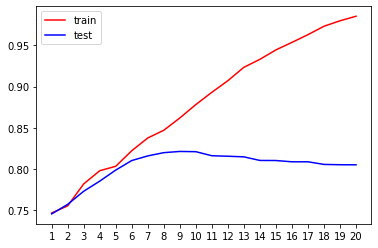

In [39]:
from sklearn.model_selection import cross_val_score
tr = []
te = []
for i in range(20):
    clf = DecisionTreeClassifier(random_state=0,max_depth=i+1,criterion='gini')
    clf = clf.fit(X_train,Y_train)
    score_tr = clf.score(X_train,Y_train)
    score_te = cross_val_score(clf,X,y,cv=10).mean()
    tr.append(score_tr)
    te.append(score_te)
    
plt.plot(range(1,21),tr,color='red',label='train')
plt.plot(range(1,21),te,color='blue',label='test')
plt.xticks(range(1,21))
plt.legend()
plt.show()

In [40]:
te.index(max(te))

8

## 7.2 网格搜索，寻找最优参数

In [ ]:
from sklearn.model_selection import GridSearchCV
gini_thresholds = np.linspace(0,0.5,20)

parameters = {
    'splitter':('best','random')
    ,'criterion':("gini","entropy")
    ,"max_depth":[*range(1,10)]
    ,'min_samples_leaf':[*range(1,50,5)]
    ,'min_impurity_decrease':[*np.linspace(0,0.5,20)]
}
clf = DecisionTreeClassifier(random_state=25)
GS = GridSearchCV(clf, parameters, cv=10)
GS.fit(X_train,Y_train)